# AWS 환경설정

* `export AWS_DEFAULT_PROFILE=ghpipeliner` 실행
* 원하는 aws profile로 잘 변경되었는지 확인
    ```
    aws s3 ls
    ```

In [1]:
import boto3
import pandas as pd
import numpy as np
import json

from datetime import datetime, timedelta

# Load Data

In [2]:
session = boto3.session.Session(profile_name='ghpipeliner')
s3 = session.client('s3')

In [3]:
from_dt = datetime(2023, 1, 2)
to_dt = datetime(2023, 1, 14)

dt = from_dt
df = pd.DataFrame()
cols = ['candle_date_time_kst', 'open', 'high', 'low', 'close', 'volume']
while(dt <= to_dt):
    print(f"Reading {dt}...")
    for hr in range(24):
        file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=1)} candles.json'
        try:
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        except:
            file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=2)} candles.json'
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        obj = json.loads(response['Body'].read().decode('utf-8'))
        df = pd.concat([df, pd.DataFrame(obj['candles'])[cols]])
    dt = dt + timedelta(days=1)
    
df.reset_index(drop=True, inplace=True)
df['candle_date_time_kst'] = df['candle_date_time_kst'].astype(dtype=np.datetime64)
df

Reading 2023-01-02 00:00:00...
Reading 2023-01-03 00:00:00...
Reading 2023-01-04 00:00:00...
Reading 2023-01-05 00:00:00...
Reading 2023-01-06 00:00:00...
Reading 2023-01-07 00:00:00...
Reading 2023-01-08 00:00:00...
Reading 2023-01-09 00:00:00...
Reading 2023-01-10 00:00:00...
Reading 2023-01-11 00:00:00...
Reading 2023-01-12 00:00:00...
Reading 2023-01-13 00:00:00...
Reading 2023-01-14 00:00:00...


,candle_date_time_kst,open,high,low,close,volume
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756
...,...,...,...,...,...,...
18715,2023-01-14 23:01:00,25982000.0,25988000.0,25969000.0,25984000.0,23.919694
18716,2023-01-14 23:02:00,25981000.0,26000000.0,25971000.0,25971000.0,20.102817
18717,2023-01-14 23:03:00,25971000.0,25980000.0,25943000.0,25948000.0,11.595073
18718,2023-01-14 23:04:00,25948000.0,25976000.0,25940000.0,25970000.0,17.004231


# Preprocess Data
* n분후 예측

In [4]:
n = 15
df['target'] = df.shift(-n)['close']
data = df.iloc[:len(df) - n]
data

,candle_date_time_kst,open,high,low,close,volume,target
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518,21097000.0
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599,21098000.0
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290,21095000.0
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292,21095000.0
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756,21095000.0
...,...,...,...,...,...,...,...
18700,2023-01-14 22:46:00,25902000.0,25936000.0,25902000.0,25936000.0,10.017290,25984000.0
18701,2023-01-14 22:47:00,25918000.0,25933000.0,25908000.0,25910000.0,6.703668,25971000.0
18702,2023-01-14 22:48:00,25910000.0,25950000.0,25878000.0,25945000.0,24.123577,25948000.0
18703,2023-01-14 22:49:00,25940000.0,25964000.0,25936000.0,25962000.0,36.878548,25970000.0


In [5]:
data_train = data.iloc[:int(len(data) * 0.8)]
data_test = data.iloc[int(len(data) * 0.8):]

print('Data for Modeling: ', str(data_train.shape))
print('Unseen Data for Predictions: ', str(data_test.shape))

Data for Modeling:  (14964, 7)
Unseen Data for Predictions:  (3741, 7)


# Train Model

* pycaret sample notebook: [regression tutorial](https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb)

In [6]:
from pycaret.regression import *

In [7]:
exp_reg001 = setup(data=data_train, target='target', session_id=1)

,Description,Value
0,session_id,1
1,Target,target
2,Original Data,"(14964, 7)"
3,Missing Values,0
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(10474, 35)"


In [8]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,141448.8220,31728365929.7185,178108.9614,0.3504,0.0083,0.0066,0.0230
gbr,Gradient Boosting Regressor,157100.3408,35311921554.9538,187908.9379,0.2771,0.0087,0.0073,0.1300
knn,K Neighbors Regressor,135682.4828,36329603481.6000,190563.2703,0.2565,0.0088,0.0063,0.0200
llar,Lasso Least Angle Regression,166253.8409,39153651447.1989,197868.5337,0.1986,0.0092,0.0077,0.0050
lasso,Lasso Regression,166307.5500,39158573056.0000,197880.9797,0.1985,0.0092,0.0077,0.0310
lar,Least Angle Regression,166314.2127,39158999206.6263,197882.0578,0.1985,0.0092,0.0077,0.0060
ridge,Ridge Regression,166321.6516,39159087513.6000,197882.2891,0.1984,0.0092,0.0077,0.0040
br,Bayesian Ridge,166478.7810,39172492510.5459,197916.1647,0.1982,0.0092,0.0077,0.0140
ada,AdaBoost Regressor,171602.2695,39515712146.2707,198774.4951,0.1912,0.0092,0.0080,0.0300
lr,Linear Regression,167543.2109,39681559347.2000,199191.7094,0.1876,0.0092,0.0078,0.5140


In [9]:
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,142095.5025,30860677526.6476,175672.0738,0.3772,0.0081,0.0066
1,142599.9914,32165489778.1088,179347.3997,0.3551,0.0083,0.0066
2,143633.9683,32911677056.9509,181415.7575,0.3028,0.0084,0.0067
3,140986.9837,30784690450.2602,175455.6652,0.3733,0.0081,0.0065
4,140560.8590,31703789191.2472,178055.5789,0.3296,0.0083,0.0065
5,135367.9575,30421236995.3950,174416.8484,0.3635,0.0081,0.0063
6,143284.9220,32184761612.1993,179401.1193,0.3421,0.0083,0.0066
7,142111.4561,33079072677.3278,181876.5314,0.3255,0.0084,0.0066
8,142396.8527,31744315748.1574,178169.3457,0.3542,0.0083,0.0066


In [10]:
tuned_lgbm = tune_model(lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,153015.5467,33661875361.6012,183471.7291,0.3206,0.0085,0.0071
1,152109.7144,34571393767.0733,185933.8424,0.3068,0.0086,0.0071
2,151753.9838,34697838663.7690,186273.5587,0.2650,0.0086,0.0070
3,149801.4300,33146492621.1518,182061.7824,0.3252,0.0084,0.0069
4,148642.7443,33114839204.6726,181974.8312,0.2997,0.0084,0.0069
5,145101.4457,32615624456.3054,180597.9636,0.3176,0.0084,0.0067
6,152235.4056,34575830585.6252,185945.7732,0.2933,0.0086,0.0071
7,149234.8196,34937512397.4144,186915.7896,0.2876,0.0087,0.0069
8,151467.7149,33834215561.3934,183940.7936,0.3117,0.0085,0.0070


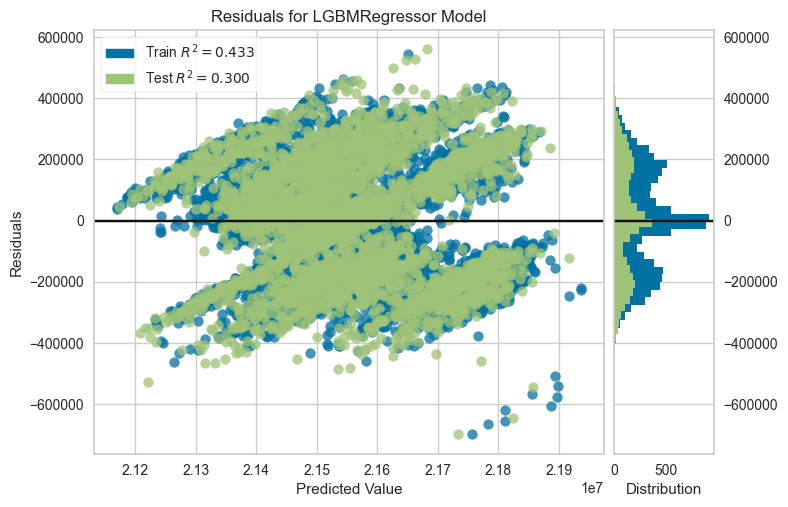

In [11]:
plot_model(tuned_lgbm)

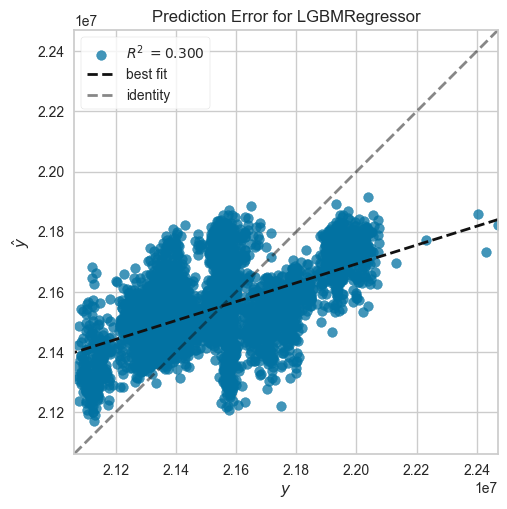

In [12]:
plot_model(tuned_lgbm, plot = 'error')

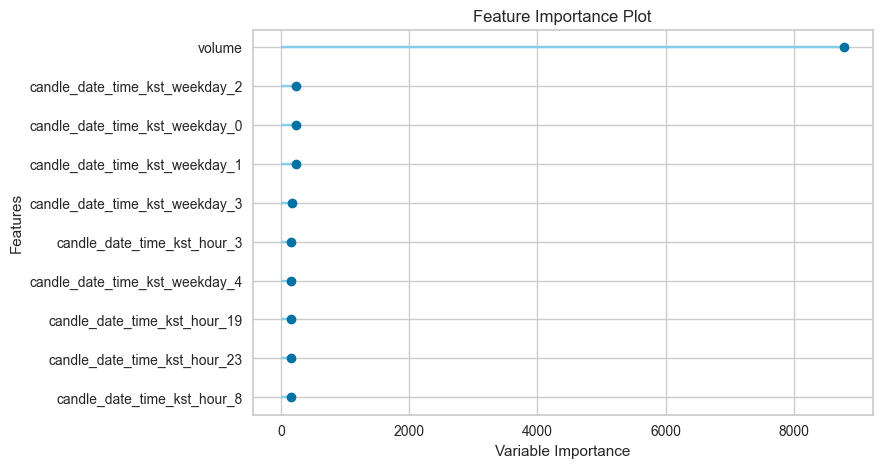

In [13]:
plot_model(tuned_lgbm, plot='feature')

In [14]:
final_lgbm = finalize_model(tuned_lgbm)
print(final_lgbm)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2[LightGBM] [Warning] 
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] [LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6[LightGBM] [Warning] 
bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9[LightGBM] [Warning] 
bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

In [15]:
unseen_predictions = predict_model(final_lgbm, data=data_test)
unseen_predictions.head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2484644.0738,7461329353530.2861,2731543.4014,-5.0340,0.1181,0.1017


,candle_date_time_kst,open,high,low,close,volume,target,Label
14964,2023-01-12 08:30:00,22132000.0,22163000.0,22120000.0,22163000.0,2.863706,22445000.0,2.193322e+07
14965,2023-01-12 08:31:00,22163000.0,22167000.0,22161000.0,22162000.0,6.822875,22451000.0,2.180055e+07
14966,2023-01-12 08:32:00,22162000.0,22240000.0,22161000.0,22230000.0,36.114889,22449000.0,2.183355e+07
14967,2023-01-12 08:33:00,22230000.0,22415000.0,22224000.0,22403000.0,60.997269,22451000.0,2.183355e+07
14968,2023-01-12 08:34:00,22400000.0,22498000.0,22377000.0,22475000.0,27.666239,22437000.0,2.183355e+07
14969,2023-01-12 08:35:00,22473000.0,22498000.0,22415000.0,22432000.0,34.066196,22437000.0,2.183355e+07
14970,2023-01-12 08:36:00,22419000.0,22460000.0,22419000.0,22448000.0,36.027856,22452000.0,2.183355e+07
14971,2023-01-12 08:37:00,22439000.0,22501000.0,22437000.0,22492000.0,34.359781,22457000.0,2.183355e+07
14972,2023-01-12 08:38:00,22499000.0,22499000.0,22449000.0,22470000.0,13.902834,22461000.0,2.183355e+07
14973,2023-01-12 08:39:00,22470000.0,22470000.0,22401000.0,22422000.0,14.684522,22472000.0,2.183355e+07


In [16]:
from pycaret.utils import check_metric

In [17]:
check_metric(unseen_predictions['target'], unseen_predictions['Label'], 'R2')

-5.034

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

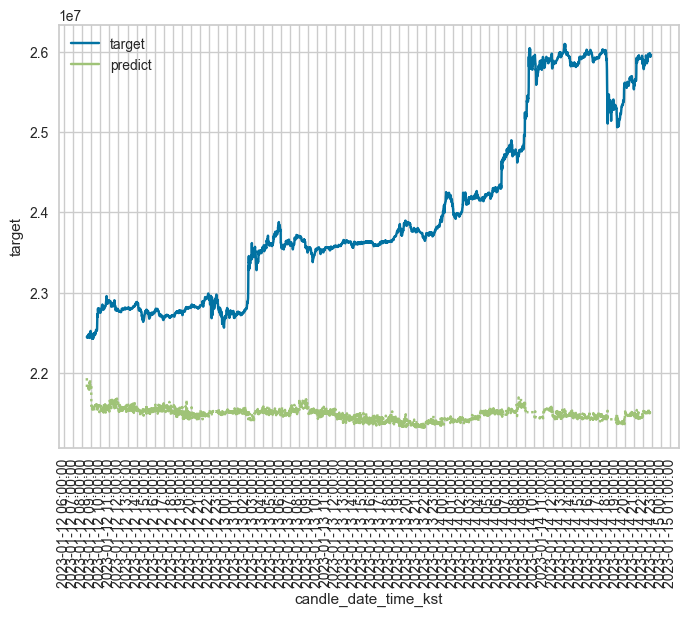

In [19]:
fig, ax = plt.subplots()

sns.lineplot(data = unseen_predictions, x='candle_date_time_kst', y='target', label='target', ax=ax)
sns.lineplot(data = unseen_predictions, x='candle_date_time_kst', y='Label', label='predict', ax=ax)

ax.lines[1].set_linestyle(":")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), rotation=90)
fig.show()